<a href="https://colab.research.google.com/github/devangi2000/Disease-Prediction/blob/master/U_Net_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## U-Net model
We'll be using a network architecture called "U-Net". The name of this network architecture comes from it's U-like shape when shown in a diagram like this (image from [U-net entry on wikipedia](https://en.wikipedia.org/wiki/U-Net)): 

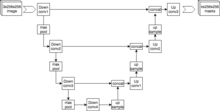

U-nets are commonly used for image segmentation. 

As you can see from the diagram, this architecture features a series of down-convolutions connected by max-pooling operations, followed by a series of up-convolutions connected by upsampling and concatenation operations. Each of the down-convolutions is also connected directly to the concatenation operations in the upsampling portion of the network. For more detail on the U-Net architecture, have a look at the original [U-Net paper by Ronneberger et al. 2015](https://arxiv.org/abs/1505.04597).  

In [8]:
# Import the elements you'll need to build your U-Net
!pip install keras==2.3.1
#import tensorflow as tf
import keras
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU , Deconvolution3D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
# Set the image shape to have the channels in the first dimension
K.set_image_data_format("channels_first")

### The "depth" of your U-Net
The "depth" of your U-Net is equal to the number of down-convolutions you will use. In the image above, the depth is 4 because there are 4 down-convolutions running down the left side including the very bottom of the U.

I've used a U-Net depth of 2, meaning there are 2 down-convolutions in the network. 

### Input layer and its "depth"

I will be doing 3D image segmentation, which is to say that, in addition to "height" and "width", the input layer will also have a "length". We are deliberately using the word "length" instead of "depth" here to describe the third spatial dimension of the input so as not to confuse it with the depth of the network as defined above.

The shape of the input layer is `(num_channels, height, width, length)`, where `num_channels` you can think of like color channels in an image, `height`, `width` and `length` are just the size of the input.

Here, the values will be:
- num_channels: 4
- height: 160
- width: 160
- length: 16

In [9]:
# Define an input layer tensor of the shape you'll use in the assignment
input_layer = Input(shape=(4, 160, 160, 16))
input_layer

<tf.Tensor 'input_2:0' shape=(None, 4, 160, 160, 16) dtype=float32>

Notice that the tensor shape has a '?' as the very first dimension.  This will be the batch size. So the dimensions of the tensor are: (batch_size, num_channels, height, width, length)

In [10]:
keras.__version__

'2.3.1'

## Contracting (downward) path 
Here you'll start by constructing the downward path in your network (the left side of the U-Net).  The `(height, width, length)` of the input gets smaller as you move down this path, and the number of channels increases.

### Depth 0

By "depth 0" here, we're referring to the depth of the first down-convolution in the U-net.

The number of filters is specified for each depth and for each layer within that depth.

The formula to use for calculating the number of filters is:
$$filters_{i} = 32 \times (2^{i})$$

Where $i$ is the current depth.

So at depth $i=0$:
$$filters_{0} = 32 \times (2^{0}) = 32$$

### Layer 0
There are two convolutional layers for each depth

In [11]:
# Define a Conv3D tensor with 32 filters
down_depth_0_layer_0 = Conv3D(filters=32, 
                              kernel_size=(3,3,3),
                              padding='same',
                              strides=(1,1,1)
                              )(input_layer)
down_depth_0_layer_0

Notice that with 32 filters, the result you get above is a tensor with 32 channels.

Run the next cell to add a relu activation to the first convolutional layer

In [11]:
# Add a relu activation to layer 0 of depth 0
down_depth_0_layer_0 = Activation('relu')(down_depth_0_layer_0)
down_depth_0_layer_0

### Depth 0, Layer 1
For layer 1 of depth 0, the formula for calculating the number of filters is:
$$filters_{i} = 32 \times (2^{i}) \times 2$$

Where $i$ is the current depth. 
- Notice that the '$\times~2$' at the end of this expression isn't there for layer 0.


So at depth $i=0$ for layer 1:
$$filters_{0} = 32 \times (2^{0}) \times 2 = 64$$


In [ ]:
# Create a Conv3D layer with 64 filters and add relu activation
down_depth_0_layer_1 = Conv3D(filters=64, 
                kernel_size=(3,3,3),
                padding='same',
                strides=(1,1,1)
               )(down_depth_0_layer_0)
down_depth_0_layer_1 = Activation('relu')(down_depth_0_layer_1)
down_depth_0_layer_1

### Max pooling
Within the U-Net architecture, there is a max pooling operation after each of the down-convolutions (not including the last down-convolution at the bottom of the U). In general, this means you'll add max pooling after each down-convolution up to (but not including) the `depth - 1` down-convolution (since you started counting at 0). 

Here:
- The overall depth of the U-Net we're constructing is 2
- So the bottom of our U is at a depth index of: $2-1 = 1$.
- So far we've only defined the $depth=0$ down-convolutions, so the next thing to do is add max pooling

In [ ]:
# Define a max pooling layer
down_depth_0_layer_pool = MaxPooling3D(pool_size=(2,2,2))(down_depth_0_layer_1)
down_depth_0_layer_pool

### Depth 1, Layer 0

At depth 1, layer 0, the formula for calculating the number of filters is:
$$filters_{i} = 32 \times (2^{i})$$

Where $i$ is the current depth.

So at depth $i=1$:
$$filters_{1} = 32 \times (2^{1}) = 64$$

Run the next cell to add a Conv3D layer to your network with relu activation

In [ ]:
# Add a Conv3D layer to your network with relu activation
down_depth_1_layer_0 = Conv3D(filters=64, 
                kernel_size=(3,3,3),
                padding='same',
                strides=(1,1,1)
               )(down_depth_0_layer_pool)
down_depth_1_layer_0 = Activation('relu')(down_depth_1_layer_0)
down_depth_1_layer_0

### Depth 1,  Layer 1

For layer 1 of depth 1 the formula you'll use for number of filters is:
$$filters_{i} = 32 \times (2^{i}) \times 2$$

Where $i$ is the current depth. 
- Notice that the '$\times 2$' at the end of this expression isn't there for layer 0.

So at depth $i=1$:
$$filters_{0} = 32 \times (2^{1}) \times 2 = 128$$

Run the next cell to add another Conv3D with 128 filters to your network.

In [ ]:
# Add another Conv3D with 128 filters to your network.
down_depth_1_layer_1 = Conv3D(filters=128, 
                kernel_size=(3,3,3),
                padding='same',
                strides=(1,1,1)
               )(down_depth_1_layer_0)
down_depth_1_layer_1 = Activation('relu')(down_depth_1_layer_1)
down_depth_1_layer_1

### No max pooling at depth 1 (the bottom of the U)

When you get to the "bottom" of the U-net, you don't need to apply max pooling after the convolutions.

## Expanding  (upward) Path

Now we work on the expanding path of the U-Net, (going up on the right side, when viewing the diagram).  The image's (height, width, length) all get larger in the expanding path.

### Depth 0, Up sampling layer 0

We'll use a pool size of (2,2,2) for upsampling.
- This is the default value for [tf.keras.layers.UpSampling3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling3D)
- As input to the upsampling at depth 1, you'll use the last layer of the downsampling.  In this case, it's the depth 1 layer 1.

Run the next cell to add an upsampling operation to your network. 
Note that you're not adding any activation to this upsampling layer.

In [ ]:
# Add an upsampling operation to your network
up_depth_0_layer_0 = UpSampling3D(size=(2,2,2))(down_depth_1_layer_1)
up_depth_0_layer_0

### Concatenate upsampled depth 0 with downsampled depth 0

Now you'll apply a concatenation operation using the layers that are both at the same depth of 0.
- up_depth_0_layer_0: shape is (?, 128, 160, 160, 16)
- depth_0_layer_1: shape is (?, 64, 160, 160, 16)

- Double check that both of these layers have the same height, width and length.
- If they're the same, then they can be concatenated along axis 1 (the channel axis).
- The (height, width, length) is (160, 160, 16) for both.

Run the next cell to check that the layers you wish to concatenate have the same height, width and length.

In [ ]:
# Print the shape of layers to concatenate
print(up_depth_0_layer_0)
print()
print(down_depth_0_layer_1)


# Add a concatenation along axis 1
up_depth_1_concat = concatenate([up_depth_0_layer_0,
                                 down_depth_0_layer_1],
                                axis=1)
up_depth_1_concat

### Up-convolution layer 1

The number of filters for this layer will be set to the number of channels in the down-convolution's layer 1 at the same depth of 0 (down_depth_0_layer_1).

Run the next cell to have a look at the shape of the down-convolution depth 0 layer 1

In [ ]:
down_depth_0_layer_1


Notice the number of channels for `depth_0_layer_1` is 64

In [ ]:
print(f"number of filters: {down_depth_0_layer_1._keras_shape[1]}")

# Add a Conv3D up-convolution with 64 filters to your network
up_depth_1_layer_1 = Conv3D(filters=64, 
                            kernel_size=(3,3,3),
                            padding='same',
                            strides=(1,1,1)
                           )(up_depth_1_concat)
up_depth_1_layer_1 = Activation('relu')(up_depth_1_layer_1)
up_depth_1_layer_1

### Up-convolution depth 0, layer 2

At layer 2 of depth 0 in the up-convolution the next step will be to add another up-convolution. The number of filters you'll want to use for this next up-convolution will need to be equal to the number of filters in the down-convolution depth 0 layer 1.

Run the next cell to remind yourself of the number of filters in down-convolution depth 0 layer 1.

In [ ]:
print(down_depth_0_layer_1)
print(f"number of filters: {down_depth_0_layer_1._keras_shape[1]}")

As you can see, the number of channels / filters in `down_depth_0_layer_1` is 64.

In [12]:
# Add a Conv3D up-convolution with 64 filters to your network
up_depth_1_layer_2 = Conv3D(filters=64, 
                            kernel_size=(3,3,3),
                            padding='same',
                            strides=(1,1,1)
                           )(up_depth_1_layer_1)
up_depth_1_layer_2 = Activation('relu')(up_depth_1_layer_2)
up_depth_1_layer_2

### Final Convolution

For the final convolution, you will set the number of filters to be equal to the number of classes in your input data.

We will be using data with 3 classes, namely:

- 1: edema
- 2: non-enhancing tumor 
- 3: enhancing tumor

Run the next cell to add a final Conv3D with 3 filters to your network.

In [ ]:
# Add a final Conv3D with 3 filters to your network.
final_conv = Conv3D(filters=3, #3 categories 
                    kernel_size=(1,1,1),
                    padding='valid',
                    strides=(1,1,1)
                    )(up_depth_1_layer_2)
final_conv

### Activation for final convolution

Run the next cell to add a sigmoid activation to your final convolution.

In [ ]:
# Add a sigmoid activation to your final convolution.
final_activation = Activation('sigmoid')(final_conv)
final_activation

In [ ]:
# Define and compile your model
model = Model(inputs=input_layer, outputs=final_activation)
model.compile(optimizer=Adam(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']
             )

model.summary()